# TME 10-11 : Visualisation de réseaux de neurones

## Chargement des librairies

In [1]:
import torch
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image
import os

torchvision.models.vgg.model_urls["vgg16"] = "http://webia.lip6.fr/~robert/cours/rdfia/vgg16-397923af.pth"
os.environ["TORCH_MODEL_ZOO"] = "/tmp/torch"

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'

## Fonctions et variables utiles

In [2]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess(img, size=224):
    transform = T.Compose([
        T.Scale(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

## Chargement du modèle

Pour ce TME, on utilisera le modèle Squeezenet qui est une modèle léger pré-appris sur ImageNet. Ce modèle sera figé puisque le but n'est pas de modifier/apprendre ses poids mais de les étudier.

In [3]:
# Chargement du modèle
model = torchvision.models.squeezenet1_1(pretrained=True)

# Modele en mode test
model.eval()

# Freeze les poids
for param in model.parameters():
    param.requires_grad = False

## Chargement d'images d'exemples

Permet de chargement dans les variables `X, y, class_names` 25 exemples de l'ensemble de validation d'ImageNet. `X` contient les images, `y` l'indice de la classe de chaque images, et `class_names` un dictionnaire permet d'obtenir le nom d'une classe à partir de son numéro.

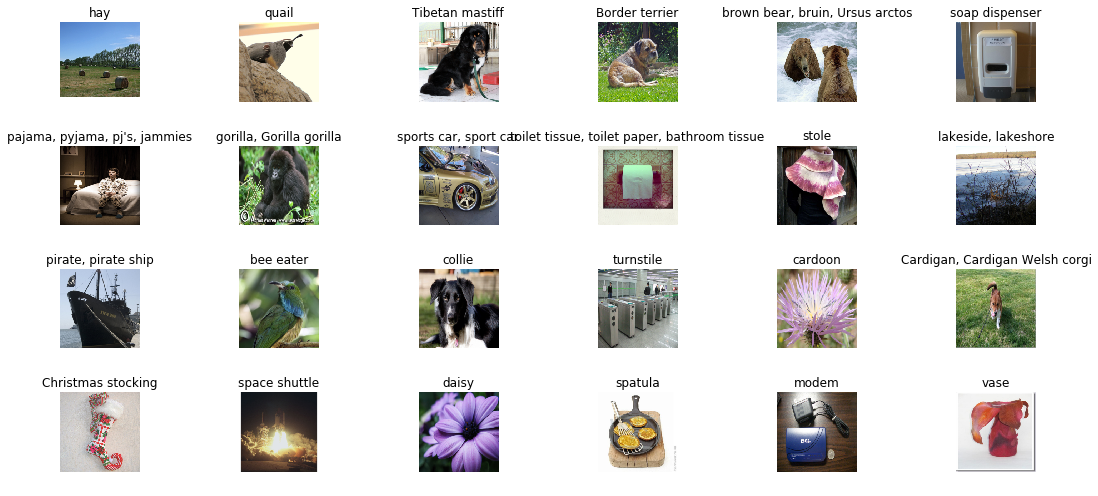

In [4]:
f = np.load("imagenet_val_25.npz")
X, y, class_names = f["X"], f["y"], f["label_map"].item()

plt.figure(figsize=(15, 7))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

# Saliency Maps

Calculez la carte de saillance pour 5 exemples parmi les 25 chargés selon les instructions du sujet de TP.

**Conseil :** Pour sélectionner 1 valeur particulière pour chaque ligne d'une matrice, vous pouvez faire comme cela :

```python
x = torch.Tensor([[0.1, 0.0, 0.5, 0.1, 0.1],
                  [0.0, 0.1, 0.0, 0.6, 0.2],
                  [0.7, 0.1, 0.1, 0.3, 0.0]])
x[np.arange(3), [2, 3, 0]]
# 0.5000
# 0.6000
# 0.7000
#[torch.FloatTensor of size 3]
```

In [5]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Wrap the input tensors in Variables
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y.float())
    
    N = y.size()[0]
    H = X.size()[2]
    W = X.size()[3]
    
    saliency = torch.Tensor((N,H,W))
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    loss = torch.nn.MSELoss()
    y_til = model(X_var)    
    for i in range(N):
        y_til[i,y[i]].backward(retain_graph=True)
    
    print(X_var.grad.data.shape)
    saliency,ind = X_var.grad.data.abs().max(1)
    
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

In [6]:
a= np.ones((3,3))

Testez votre code avec la fonction ci-dessous :

torch.Size([5, 3, 224, 224])


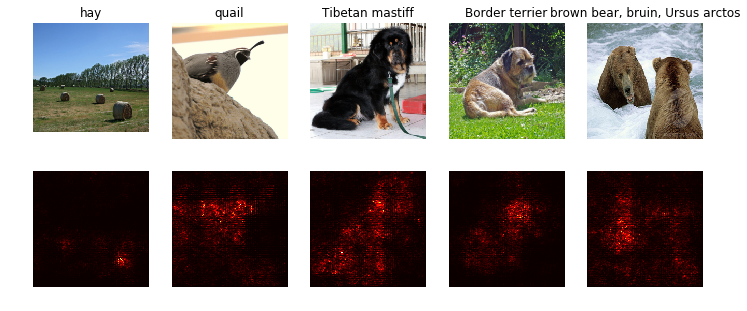

In [7]:
def show_saliency_maps(X, y, model):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

for i in range(1): # range(5) pour tester toutes les images
    show_saliency_maps(X[5*i:5*i+5], y[5*i:5*i+5], model)

# Fooling Images

Ecrire le code pour calculer une image de facon à ce qu'elle soit classée dans une classe `target_y` autre que la classe réelle (en modifiant l'image et pas les poids du réseau). Voir le sujet de TP pour les instructions.

Les 2 premiers blocs permettent de faire des tests de facon interractive pour écrire votre code. Une fois que votre code semble fonctionner, compléter la fonction dans le 3e bloc et tester sur differentes images avec le 4e bloc.

In [8]:
# Init du test
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[0])))
target_y = 6
X_fooling = X_tensor.clone()
X_fooling_var = Variable(X_fooling, requires_grad=True)
learning_rate = 0.1

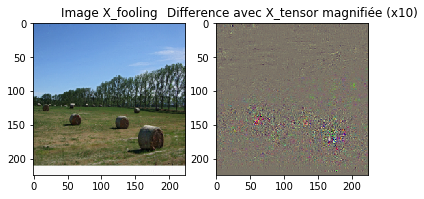

In [9]:
# TODO ecrire votre code a tester ici
cpt = 0
max_ind = -1
while(not max_ind == target_y):
    #optim.zero_grad()
    y_til = model(X_fooling_var) 
    #print(y_til.data.shape)
    y_til[0,target_y].backward()
    grad = X_fooling_var.grad
    #print(grad.data.shape)
    #print(X_fooling_var.data.shape)
    X_fooling_var.data += learning_rate * (grad.data / grad.data.norm())
    _,max_ind = torch.max(F.softmax(model(X_fooling_var)),1)
    cpt += 1
    #print(cpt)
    max_ind = max_ind.data[0]
    #print(max_ind)
#print("number of iterations needed: " + str(cpt)

# Affichage de l'image X_fooling et ses modifs
plt.subplot(1, 2, 1)
plt.imshow(np.asarray(deprocess(X_fooling.clone())).astype(np.uint8))
plt.title("Image X_fooling")
plt.subplot(1, 2, 2)
plt.imshow(np.asarray(deprocess(10* (X_fooling - X_tensor), should_rescale=False)))
plt.title("Difference avec X_tensor magnifiée (x10)")
plt.show()

In [10]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and wrap it in a Variable.
    X_fooling = X.clone()
    X_fooling_var = Variable(X_fooling, requires_grad=True)
    
    learning_rate = 1
    
    cpt = 0
    max_ind = -1
    while(not max_ind == target_y):
        #optim.zero_grad()
        y_til = model(X_fooling_var) 
        #print(y_til.data.shape)
        y_til[0,target_y].backward()
        grad = X_fooling_var.grad
        #print(grad.data.shape)
        #print(X_fooling_var.data.shape)
        X_fooling_var.data += learning_rate * (grad.data / grad.data.norm())
        _,max_ind = torch.max(F.softmax(model(X_fooling_var)),1)
        cpt += 1
        #print(cpt)
        max_ind = max_ind.data[0]
        #print(max_ind)
    print("number of iterations needed: " + str(cpt))
    
    
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling_var.data

number of iterations needed: 12


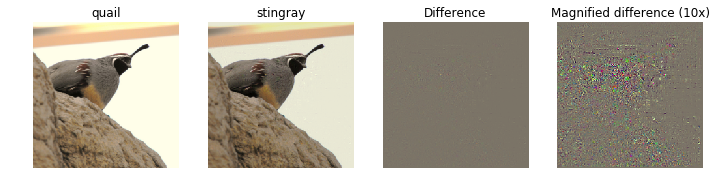

In [11]:
# Indice de l'image a modifier et de la classe cible
idx = 1
target_y = 6

# Preparation du tenseur X et sa version "fooling"
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

# verification de la classe predite
scores = model(Variable(X_fooling))
assert target_y == scores.data.max(1)[1][0], 'The model is not fooled!'

# Affichage
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

# Class visualization

Ecrire le code permettant de calculer une image maximisant le score d'une classe, sujet à un certain nombre de régularisations. Voir le sujet pour les details.

In [12]:
def create_class_visualization(target_y, model, dtype, init_img=None, l2_reg=1e-3, learning_rate=5,
                               num_iterations=200, blur_every=10, max_jitter=16, show_every=25):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - init_img: Initial image to use (if None, will be random)
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)

    # Randomly initialize the image as a PyTorch Tensor, and also wrap it in
    # a PyTorch Variable.
    if init_img is None:
        img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype)
    else:
        img = init_img.clone().mul_(1.0).type(dtype)
    img_var = Variable(img, requires_grad=True)

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.copy_(jitter(img, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        y_til = model(img_var) 
        #print(y_til.data.shape)
        loss = y_til - (l2_reg * img_var.data.norm())
        loss[0,target_y].backward()
        grad = img_var.grad.data
        #print(grad.data.shape)
        #print(X_fooling_var.data.shape)
        img_var.data += learning_rate * grad
        #print(F.softmax(model(img_var))[0,target_y])
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        # Undo the random jitter
        img.copy_(jitter(img, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.cpu())

Test avec diverses classes en partant d'un bruit aléatoire :

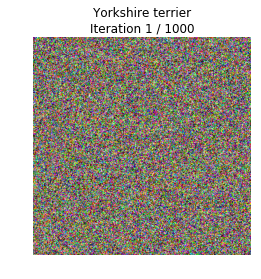

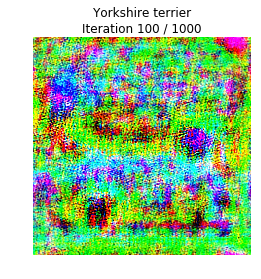

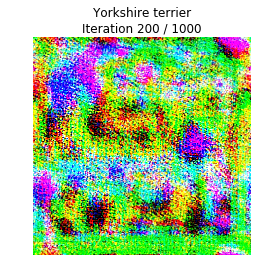

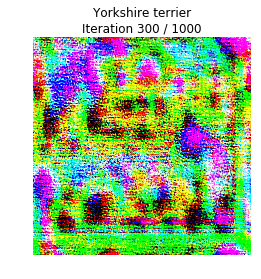

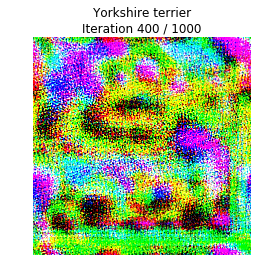

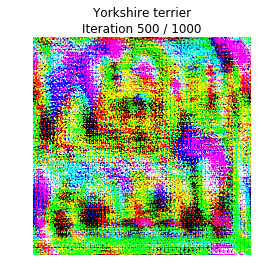

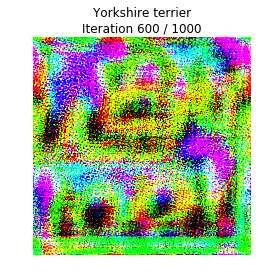

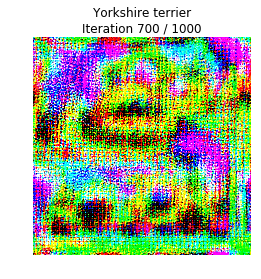

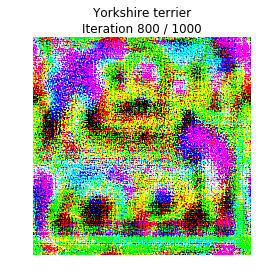

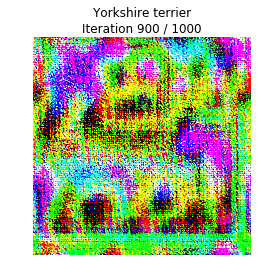

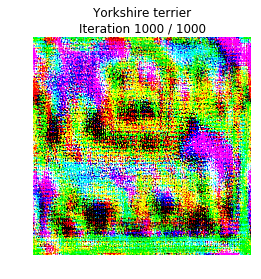

In [16]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)

#target_y = 76 # Tarantula
# target_y = 78 # Tick
target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
#target_y = 366 # Gorilla
# target_y = 604 # Hourglass
# target_y = np.random.randint(1000) # Classe aléatoire
out = create_class_visualization(target_y, model, dtype, show_every=100, num_iterations=1000)

Test en partant d'une image d'ImageNet :

In [ ]:
# Init du test
img_ind = 0

target_y = y[img_ind]
X_tensor = torch.Tensor(preprocess(Image.fromarray(X[img_ind])))
out = create_class_visualization(target_y, model, dtype, init_img=X_tensor, show_every=100, num_iterations=1000)